In [498]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os

# Load the data
experiment_folder = pathlib.Path(os.path.abspath('')).parent / "experiments" / "h1_teleop_experiments" / "2024-09-09_16-10-24"
data = pd.read_csv(experiment_folder / "data.csv")

data['delta_x'] = data['x'].diff()
data['delta_y'] = data['y'].diff()
data['delta_theta'] = data['theta'].diff()

data['prev_vx'] = data['vx'].shift(1)
data['prev_vy'] = data['vy'].shift(1)
data['prev_omega'] = data['omega'].shift(1)

forward_policy = data.loc[data['command'] == 'FORWARD']
right_policy = data.loc[data['command'] == 'RIGHT']
left_policy = data.loc[data['command'] == 'LEFT']



In [499]:
print("Data ranges")
cols = ['x', 'y', 'theta', 'vx', 'vy', 'omega', 'delta_x', 'delta_y', 'delta_theta', 'prev_vx', 'prev_vy', 'prev_omega']
for col in cols:
    print(f"{col}: {data[col].min()} - {data[col].max()}")

Data ranges
x: -0.0020927133830065 - 4.997130637108016
y: -0.4883309582630504 - 2.9686240017590126
theta: -3.1413279336873394 - 3.1414698513627526
vx: -0.6358895559719963 - 0.7453282882250113
vy: -0.5209009283374277 - 0.6808111705459325
omega: -6.7969171427339 - 6.761901448023125
delta_x: -0.0012717791119429833 - 0.001490656576450089
delta_y: -0.0010418018566748025 - 0.0013616223410919115
delta_theta: -6.282797785050092 - 6.280975528419811
prev_vx: -0.6358895559719963 - 0.7453282882250113
prev_vy: -0.5209009283374277 - 0.6808111705459325
prev_omega: -6.7969171427339 - 6.761901448023125


In [500]:
print("Mean and std")
print("FORWARD")
fw_stats = pd.DataFrame()
fw_stats['mean'] = forward_policy.loc[:, cols].mean()
fw_stats['std'] = forward_policy.loc[:, cols].std()
print(fw_stats)
print("RIGHT")
right_stats = pd.DataFrame()
right_stats['mean'] = right_policy.loc[:, cols].mean()
right_stats['std'] = right_policy.loc[:, cols].std()
print(right_stats)
print("LEFT")
left_stats = pd.DataFrame()
left_stats['mean'] = left_policy.loc[:, cols].mean()
left_stats['std'] = left_policy.loc[:, cols].std()
print(left_stats)

Mean and std
FORWARD
                 mean       std
x            2.664947  1.626548
y            0.661024  0.664184
theta        0.657937  1.015623
vx           0.191182  0.257158
vy           0.114717  0.232830
omega        0.035620  0.932302
delta_x      0.000382  0.000514
delta_y      0.000229  0.000466
delta_theta  0.000073  0.097579
prev_vx      0.191194  0.256914
prev_vy      0.114670  0.232728
prev_omega   0.035120  0.932046
RIGHT
                 mean       std
x            2.510960  1.527084
y            0.614668  1.065287
theta        0.589095  1.720673
vx           0.059650  0.296363
vy           0.031728  0.254751
omega       -1.405398  1.396356
delta_x      0.000119  0.000593
delta_y      0.000063  0.000510
delta_theta -0.001050  0.105434
prev_vx      0.059377  0.296731
prev_vy      0.031549  0.254889
prev_omega  -1.402440  1.400489
LEFT
                     mean       std
x            3.648162e+00  0.678681
y            1.267964e+00  0.676955
theta        7.278268e-01  1

array([[<Axes: title={'center': 'omega'}>]], dtype=object)

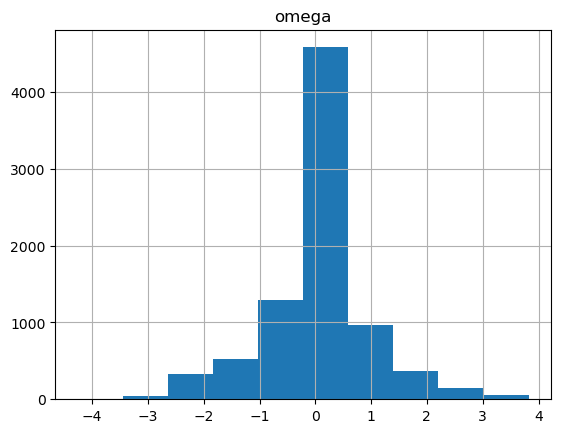

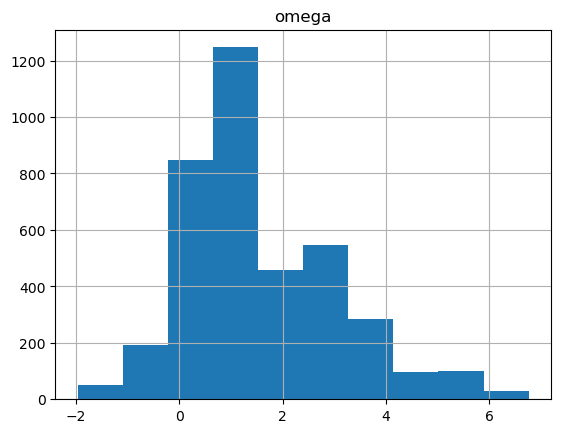

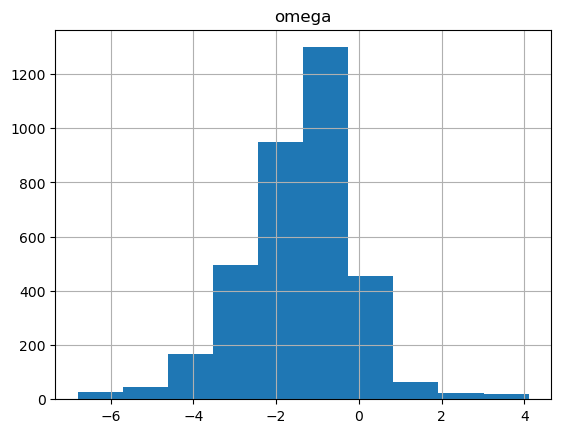

In [6]:
forward_policy.hist(column='omega', bins=10)
left_policy.hist(column='omega', bins=10)
right_policy.hist(column='omega', bins=10)

# Regression with AR-X models

## $v_x$ $v_y$ $\omega$ model

In [501]:

fw_arr = forward_policy[['prev_vx', 'prev_vy', 'prev_omega','vx','vy','omega']].to_numpy()
fw_arr = np.stack(np.split(fw_arr, 2, axis=1), axis=1)


fw_exog = fw_arr[:,0,:]
fw_exog = np.append(fw_exog, np.ones((fw_arr.shape[0], 1)), axis=1)
fw_endog = fw_arr[:,1,:]

left_arr = left_policy[['prev_vx', 'prev_vy', 'prev_omega','vx','vy','omega']].to_numpy()
left_arr = np.stack(np.split(left_arr, 2, axis=1), axis=1)

left_exog = left_arr[:,0,:]
left_exog = np.append(left_exog, np.ones((left_arr.shape[0], 1)), axis=1)
left_endog = left_arr[:,1,:]

right_arr = right_policy[['prev_vx', 'prev_vy', 'prev_omega','vx','vy','omega']].to_numpy()
right_arr = np.stack(np.split(right_arr, 2, axis=1), axis=1)    

right_exog = right_arr[:,0,:]
right_exog = np.append(right_exog, np.ones((right_arr.shape[0], 1)), axis=1)
right_endog = right_arr[:,1,:]

In [502]:
import statsmodels.regression.linear_model as sm

fw_vx_model = sm.OLS(fw_endog[:,0], fw_exog).fit()
fw_vy_model = sm.OLS(fw_endog[:,1], fw_exog).fit()
fw_omega_model = sm.OLS(fw_endog[:,2], fw_exog).fit()

left_vx_model = sm.OLS(left_endog[:,0], left_exog).fit()
left_vy_model = sm.OLS(left_endog[:,1], left_exog).fit()
left_omega_model = sm.OLS(left_endog[:,2], left_exog).fit()

right_vx_model = sm.OLS(right_endog[:,0], right_exog).fit()
right_vy_model = sm.OLS(right_endog[:,1], right_exog).fit()
right_omega_model = sm.OLS(right_endog[:,2], right_exog).fit()

In [66]:
pd.Series(data['vx']).diff().to_numpy()

array([            nan, -7.03507929e-07, -6.89660969e-07, ...,
        3.26410302e-03,  3.34426414e-03,  3.42555004e-03])

Text(0.5, 1.0, 'Right omega')

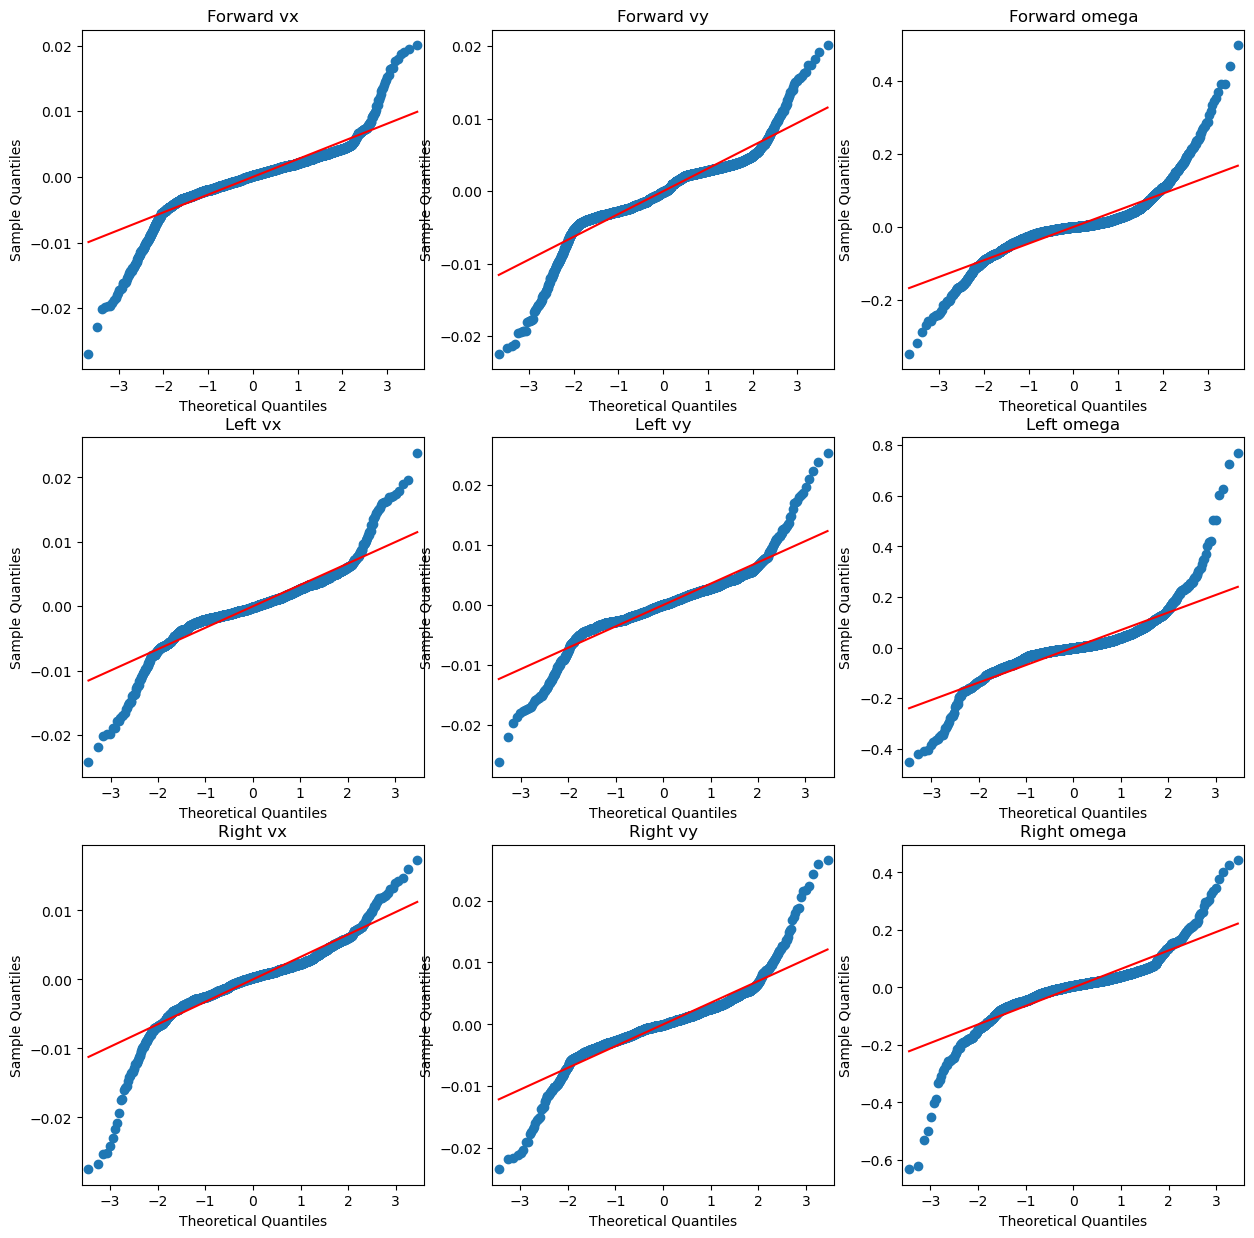

In [11]:
#plot qq plot
import statsmodels.api as sm_api
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
sm_api.qqplot(fw_vx_model.resid, line='s', ax=ax[0,0])
ax[0,0].set_title('Forward vx')
sm_api.qqplot(fw_vy_model.resid, line='s', ax=ax[0,1])
ax[0,1].set_title('Forward vy')
sm_api.qqplot(fw_omega_model.resid, line='s', ax=ax[0,2])
ax[0,2].set_title('Forward omega')
sm_api.qqplot(left_vx_model.resid, line='s', ax=ax[1,0])
ax[1,0].set_title('Left vx')
sm_api.qqplot(left_vy_model.resid, line='s', ax=ax[1,1])
ax[1,1].set_title('Left vy')
sm_api.qqplot(left_omega_model.resid, line='s', ax=ax[1,2])
ax[1,2].set_title('Left omega')
sm_api.qqplot(right_vx_model.resid, line='s', ax=ax[2,0])
ax[2,0].set_title('Right vx')
sm_api.qqplot(right_vy_model.resid, line='s', ax=ax[2,1])
ax[2,1].set_title('Right vy')
sm_api.qqplot(right_omega_model.resid, line='s', ax=ax[2,2])
ax[2,2].set_title('Right omega')

Text(0.5, 1.0, 'Right omega')

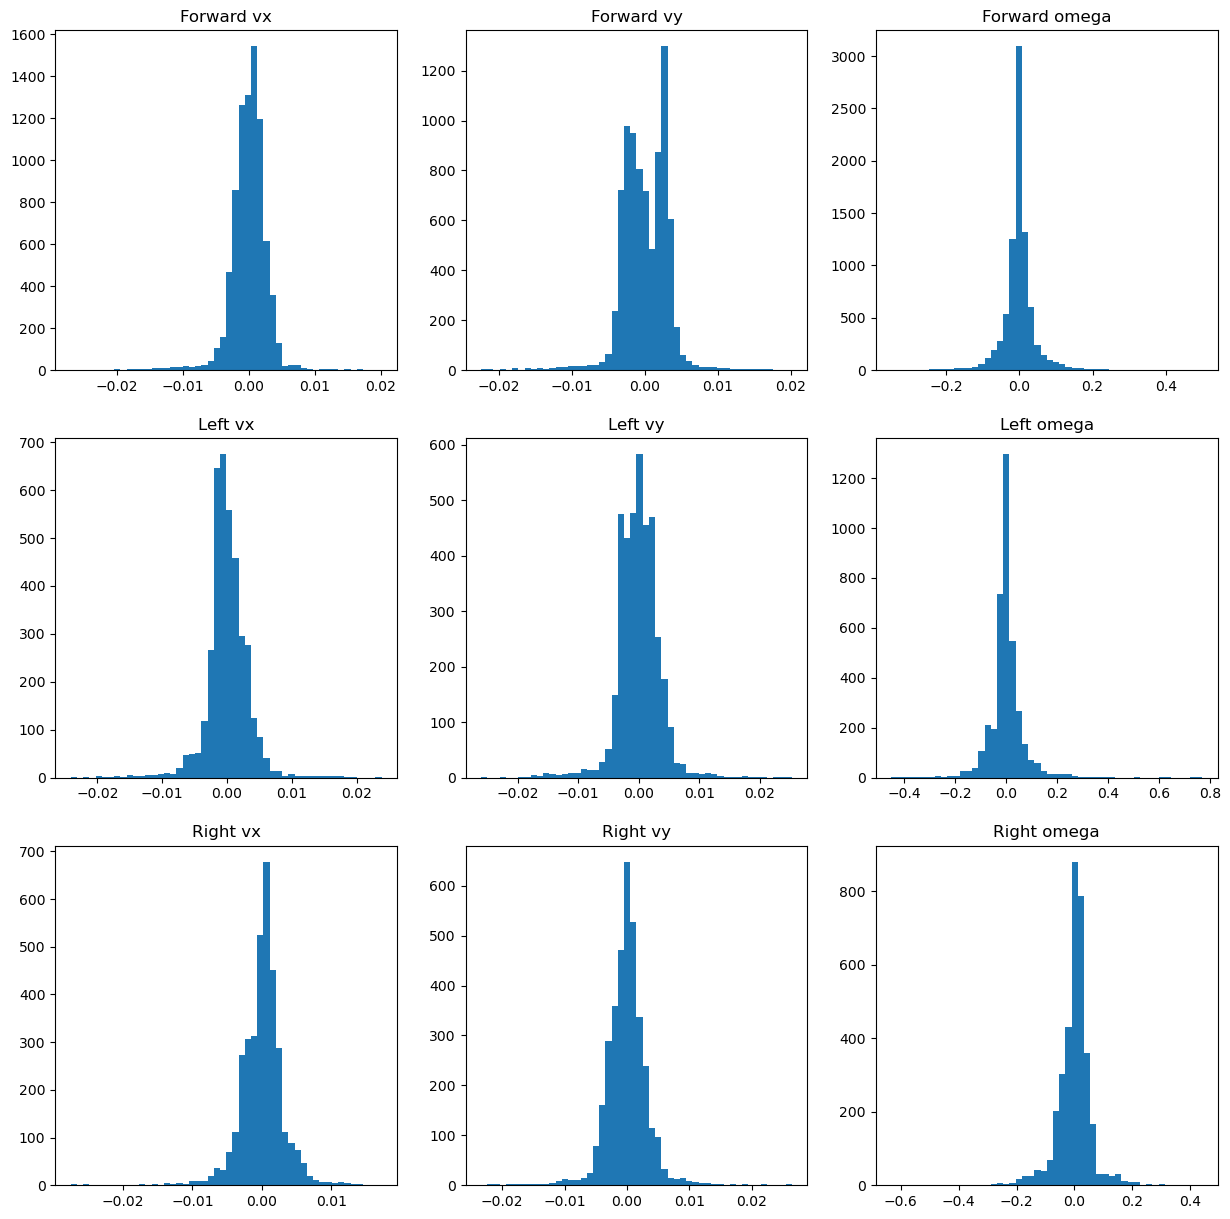

In [127]:
#plot residuals histogram
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0,0].hist(fw_vx_model.resid, bins=50)
ax[0,0].set_title('Forward vx')
ax[0,1].hist(fw_vy_model.resid, bins=50)
ax[0,1].set_title('Forward vy')
ax[0,2].hist(fw_omega_model.resid, bins=50)
ax[0,2].set_title('Forward omega')
ax[1,0].hist(left_vx_model.resid, bins=50)
ax[1,0].set_title('Left vx')
ax[1,1].hist(left_vy_model.resid, bins=50)
ax[1,1].set_title('Left vy')
ax[1,2].hist(left_omega_model.resid, bins=50)
ax[1,2].set_title('Left omega')
ax[2,0].hist(right_vx_model.resid, bins=50)
ax[2,0].set_title('Right vx')
ax[2,1].hist(right_vy_model.resid, bins=50)
ax[2,1].set_title('Right vy')
ax[2,2].hist(right_omega_model.resid, bins=50)
ax[2,2].set_title('Right omega')

In [12]:
#heteriscedasticity test
import statsmodels.stats.diagnostic as sm_diag
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sm_diag.het_breuschpagan(fw_vx_model.resid, fw_exog)
print("Forward vx")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(fw_vy_model.resid, fw_exog)
print("Forward vy")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(fw_omega_model.resid, fw_exog)
print("Forward omega")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(left_vx_model.resid, left_exog)
print("Left vx")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(left_vy_model.resid, left_exog)
print("Left vy")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(left_omega_model.resid, left_exog)
print("Left omega")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(right_vx_model.resid, right_exog)
print("Right vx")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(right_vy_model.resid, right_exog)
print("Right vy")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(right_omega_model.resid, right_exog)
print("Right omega")
print(list(zip(name, test)))

Forward vx
[('Lagrange multiplier statistic', 130.3835207866642), ('p-value', 4.471188809745976e-28), ('f-value', 44.13409215671875), ('f p-value', 2.7488141840354852e-28)]
Forward vy
[('Lagrange multiplier statistic', 83.15738479613495), ('p-value', 6.4509735512328685e-18), ('f-value', 27.98638962532839), ('f p-value', 5.334819736681951e-18)]
Forward omega
[('Lagrange multiplier statistic', 60.69945385234649), ('p-value', 4.166768652802917e-13), ('f-value', 20.372505844980935), ('f p-value', 3.780877652944699e-13)]
Left vx
[('Lagrange multiplier statistic', 73.21185910264977), ('p-value', 8.755734349974263e-16), ('f-value', 24.850933096600023), ('f p-value', 6.392838311241102e-16)]
Left vy
[('Lagrange multiplier statistic', 29.94282268679011), ('p-value', 1.4188088341735494e-06), ('f-value', 10.048688123827347), ('f p-value', 1.3585088383876993e-06)]
Left omega
[('Lagrange multiplier statistic', 61.85665701663666), ('p-value', 2.357702609985151e-13), ('f-value', 20.9336336087543), ('f

In [503]:
models = [fw_vx_model, fw_vy_model, fw_omega_model, left_vx_model, left_vy_model, left_omega_model, right_vx_model, right_vy_model, right_omega_model]
for model in models:
    display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.497e+07
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:10:46   Log-Likelihood:                 37266.
No. Observations:                8293   AIC:                        -7.452e+04
Df Residuals:                    8289   BIC:                        -7.450e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0009      0.000   8474.553      0.000       1.001       1.001
x2         -8.638e-05      0.000     -0.658      0.510      -0.000       0.000
x3             0.0004   3.21e-05     11.869      0.000       0.000       0.000
const         -0.0002   4.18e-05     -4.708      0.000      -0.000      -0.000
==============================================================================
Omnibus:                     2497.531   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45116.128
Skew:                          -0.977   Prob(JB):                         0.00
Kurtosis:                      14.258   Cond. No.                         4.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.516e+07
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:10:46   Log-Likelihood:                 36023.
No. Observations:                8293   AIC:                        -7.204e+04
Df Residuals:                    8289   BIC:                        -7.201e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0001      0.000     -0.837      0.403      -0.000       0.000
x2             1.0005      0.000   6564.582      0.000       1.000       1.001
x3            -0.0003   3.73e-05     -8.603      0.000      -0.000      -0.000
const       2.553e-05   4.86e-05      0.525      0.600   -6.98e-05       0.000
==============================================================================
Omnibus:                     1339.649   Durbin-Watson:                   0.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11377.435
Skew:                          -0.524   Prob(JB):                         0.00
Kurtosis:                       8.642   Cond. No.                         4.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.145e+06
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:10:46   Log-Likelihood:                 13816.
No. Observations:                8293   AIC:                        -2.762e+04
Df Residuals:                    8289   BIC:                        -2.760e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0033      0.002     -1.656      0.098      -0.007       0.001
x2             0.0067      0.002      3.029      0.002       0.002       0.011
x3             0.9988      0.001   1838.411      0.000       0.998       1.000
const          0.0004      0.001      0.571      0.568      -0.001       0.002
==============================================================================
Omnibus:                     2518.923   Durbin-Watson:                   0.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59142.737
Skew:                           0.911   Prob(JB):                         0.00
Kurtosis:                      15.955   Cond. No.                         4.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.697e+06
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:10:46   Log-Likelihood:                 16524.
No. Observations:                3852   AIC:                        -3.304e+04
Df Residuals:                    3848   BIC:                        -3.302e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9991      0.000   4370.005      0.000       0.999       1.000
x2            -0.0012      0.000     -6.042      0.000      -0.002      -0.001
x3             0.0004    3.6e-05     12.278      0.000       0.000       0.001
const         -0.0007   8.03e-05     -8.651      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      659.926   Durbin-Watson:                   0.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11444.166
Skew:                          -0.267   Prob(JB):                         0.00
Kurtosis:                      11.427   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.524e+06
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:10:46   Log-Likelihood:                 16268.
No. Observations:                3852   AIC:                        -3.253e+04
Df Residuals:                    3848   BIC:                        -3.250e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0001      0.000     -0.583      0.560      -0.001       0.000
x2             1.0000      0.000   4633.071      0.000       1.000       1.000
x3            -0.0002   3.85e-05     -4.527      0.000      -0.000   -9.87e-05
const          0.0001   8.58e-05      1.345      0.179   -5.28e-05       0.000
==============================================================================
Omnibus:                      580.473   Durbin-Watson:                   0.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8556.685
Skew:                          -0.171   Prob(JB):                         0.00
Kurtosis:                      10.294   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 5.894e+05
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:10:46   Log-Likelihood:                 4822.8
No. Observations:                3852   AIC:                            -9638.
Df Residuals:                    3848   BIC:                            -9613.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0139      0.005     -2.920      0.004      -0.023      -0.005
x2             0.0096      0.004      2.282      0.023       0.001       0.018
x3             0.9983      0.001   1329.618      0.000       0.997       1.000
const          0.0030      0.002      1.812      0.070      -0.000       0.006
==============================================================================
Omnibus:                     1502.917   Durbin-Watson:                   0.220
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51738.773
Skew:                           1.199   Prob(JB):                         0.00
Kurtosis:                      20.794   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.767e+06
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:10:46   Log-Likelihood:                 15268.
No. Observations:                3544   AIC:                        -3.053e+04
Df Residuals:                    3540   BIC:                        -3.050e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9994      0.000   5179.264      0.000       0.999       1.000
x2             0.0029      0.000     12.809      0.000       0.002       0.003
x3          7.131e-05   3.98e-05      1.791      0.073   -6.75e-06       0.000
const          0.0003   7.88e-05      4.044      0.000       0.000       0.000
==============================================================================
Omnibus:                     1181.680   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16193.166
Skew:                          -1.197   Prob(JB):                         0.00
Kurtosis:                      13.195   Cond. No.                         9.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.215e+06
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:10:46   Log-Likelihood:                 15003.
No. Observations:                3544   AIC:                        -3.000e+04
Df Residuals:                    3540   BIC:                        -2.997e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0007      0.000     -3.312      0.001      -0.001      -0.000
x2             0.9990      0.000   4155.979      0.000       0.999       0.999
x3             0.0002   4.29e-05      4.698      0.000       0.000       0.000
const          0.0005    8.5e-05      6.285      0.000       0.000       0.001
==============================================================================
Omnibus:                      620.149   Durbin-Watson:                   0.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13203.737
Skew:                           0.147   Prob(JB):                         0.00
Kurtosis:                      12.451   Cond. No.                         9.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 5.537e+05
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:10:46   Log-Likelihood:                 4692.3
No. Observations:                3544   AIC:                            -9377.
Df Residuals:                    3540   BIC:                            -9352.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0043      0.004     -1.130      0.258      -0.012       0.003
x2            -0.0122      0.004     -2.770      0.006      -0.021      -0.004
x3             0.9961      0.001   1265.591      0.000       0.995       0.998
const         -0.0078      0.002     -4.989      0.000      -0.011      -0.005
==============================================================================
Omnibus:                     1087.707   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27918.914
Skew:                          -0.884   Prob(JB):                         0.00
Kurtosis:                      16.636   Cond. No.                         9.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
import pickle
fw_coeffs = np.stack([fw_vx_model.params, fw_vy_model.params, fw_omega_model.params], axis=0)
fw_cov = np.diag([fw_vx_model.resid.var(), fw_vy_model.resid.var(), fw_omega_model.resid.var()])
left_coeffs = np.stack([left_vx_model.params, left_vy_model.params, left_omega_model.params], axis=0)
left_cov = np.diag([left_vx_model.resid.var(), left_vy_model.resid.var(), left_omega_model.resid.var()])
right_coeffs = np.stack([right_vx_model.params, right_vy_model.params, right_omega_model.params], axis=0)
right_cov = np.diag([right_vx_model.resid.var(), right_vy_model.resid.var(), right_omega_model.resid.var()])
models = {
    'FORWARD': {
        'coeffs': fw_coeffs,
        'cov': fw_cov
    },
    'LEFT': {
        'coeffs': left_coeffs,
        'cov': left_cov
    },
    'RIGHT': {
        'coeffs': right_coeffs,
        'cov': right_cov
    }
}
with open(experiment_folder / 'models_ols.pkl', 'wb') as f:
    pickle.dump(models, f)

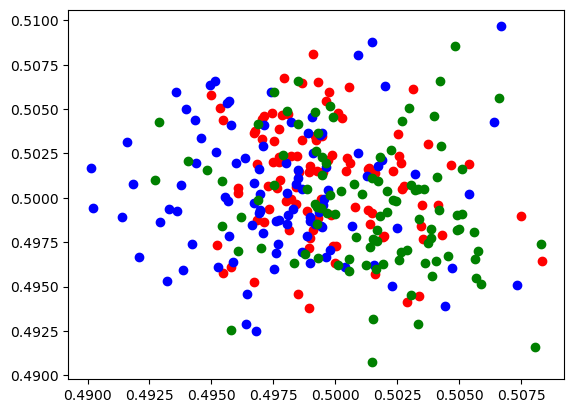

In [23]:
state = np.array([0.5,0.5,-1.0])

fw_samples = np.random.multivariate_normal(np.dot(models['FORWARD']['coeffs'], np.append(state, 1)), models['FORWARD']['cov'], 100)
left_samples = np.random.multivariate_normal(np.dot(models['LEFT']['coeffs'], np.append(state, 1)), models['LEFT']['cov'], 100)
right_samples = np.random.multivariate_normal(np.dot(models['RIGHT']['coeffs'], np.append(state, 1)), models['RIGHT']['cov'], 100)
plt.scatter(fw_samples[:,0], fw_samples[:,1], c='r', label='forward')
plt.scatter(left_samples[:,0], left_samples[:,1], c='b', label='left')
plt.scatter(right_samples[:,0], right_samples[:,1], c='g', label='right')

## $v_{fw}$ $v_n$ $\omega$ model

In [1963]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os

# Load the data
experiment_folder = pathlib.Path(os.path.abspath('')).parent / "experiments" / "h1_teleop_experiments" / "2024-09-09_16-10-24"
df = pd.read_csv(experiment_folder / "data.csv")

timestep = 0.002
decimation_index = 10
new_timestep = timestep * decimation_index

df = df.iloc[::decimation_index, :]

df['time'] = pd.to_timedelta(df['time'], unit='s')
df['x_prev'] = df['x'].shift(1)
df['y_prev'] = df['y'].shift(1)
df['theta_prev'] = df['theta'].shift(1)

df['v_mod'] = np.sqrt(df['vx']**2 + df['vy']**2)
df['v_fw'] = np.cos(df['theta'])*df['vx'] + np.sin(df['theta'])*df['vy']
#df['v_ang'] = np.arctan2(df['vy'], df['vx'])

# _calc values are calculated from the data after decimation. They describe the overall movement of the robot on a larger scale

df['vx_calc'] = (df['x'] - df['x_prev'])/new_timestep
df['vy_calc'] = (df['y'] - df['y_prev'])/new_timestep
df['v_fw_calc'] = np.cos(df['theta_prev'])*df['vx_calc'] + np.sin(df['theta_prev'])*df['vy_calc']
df['v_n_calc'] = -np.sin(df['theta_prev'])*df['vx_calc'] + np.cos(df['theta_prev'])*df['vy_calc']
df['omega_calc'] = df['theta'].diff()
df.loc[df['omega_calc'] < -np.pi, 'omega_calc'] = df.loc[df['omega_calc'] < -np.pi, 'omega_calc'] + 2*np.pi
df.loc[df['omega_calc'] > np.pi, 'omega_calc'] = df.loc[df['omega_calc'] > np.pi, 'omega_calc'] - 2*np.pi
df['omega_calc'] = df['omega_calc']/new_timestep


# Difference between current and previous values
df['v_mod_diff'] = df['v_mod'].diff()
df['omega_calc_diff'] = df['omega_calc'].diff()

# Previous values
df['prev_v_mod'] = df['v_mod'].shift(1)
df['prev_omega_calc'] = df['omega_calc'].shift(1)
df['v_fw_calc_prev'] = df['v_fw_calc'].shift(1)
df['v_n_calc_prev'] = df['v_n_calc'].shift(1)
df['omega_calc_prev'] = df['omega_calc'].shift(1)
df['v_fw_calc_prev_prev'] = df['v_fw_calc'].shift(2)
df['v_n_calc_prev_prev'] = df['v_n_calc'].shift(2)
df['omega_calc_prev_prev'] = df['omega_calc'].shift(2)
df['v_fw_calc_prev_prev_prev'] = df['v_fw_calc'].shift(3)
df['v_n_calc_prev_prev_prev'] = df['v_n_calc'].shift(3)
df['omega_calc_prev_prev_prev'] = df['omega_calc'].shift(3)

forward_df = df.loc[df['command'] == 'FORWARD']
right_df = df.loc[df['command'] == 'RIGHT']
left_df = df.loc[df['command'] == 'LEFT']

<Axes: >

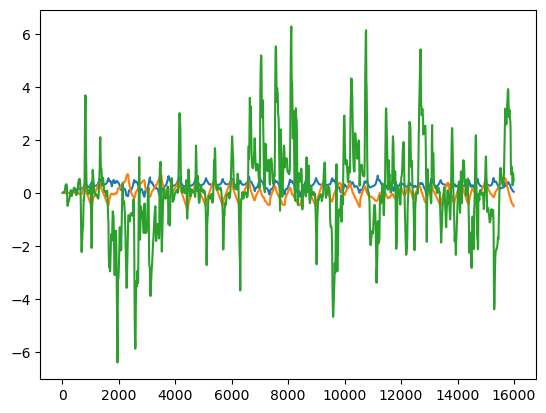

In [1964]:
df['v_fw_calc'].plot()
df['v_n_calc'].plot()
df['omega_calc'].plot()

Motion model with instant velocities validation:

0.25650579539950996 0.07679389815700155
0.2191880667764229 0.07821948277917934


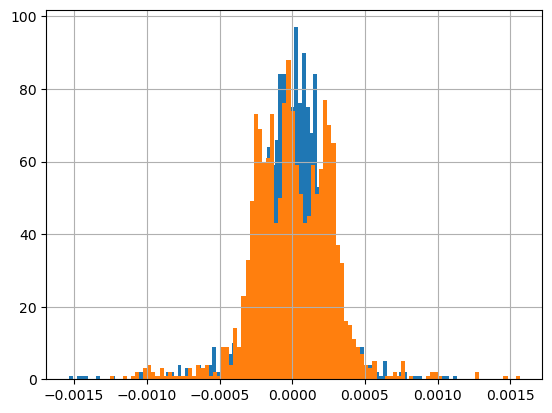

In [1965]:
x_new = df['x'].shift(1) + df['vx']*new_timestep
y_new = df['y'].shift(1) + df['vy']*new_timestep
x_error = x_new - df['x']
y_error = y_new - df['y']
(x_error).hist(bins=100)
(y_error).hist(bins=100)
print(np.abs(df['vx']).mean(), np.abs(x_error).max()/new_timestep)
print(np.abs(df['vy']).mean(), np.abs(y_error).max()/new_timestep)

1.0622906597303583 0.07679389815700155


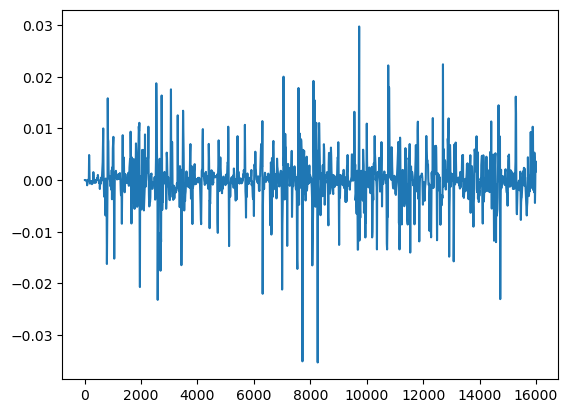

In [1966]:
theta_new = df['theta'].shift(1) + df['omega']*new_timestep
theta_new.loc[theta_new < -np.pi] = theta_new.loc[theta_new < -np.pi] + 2*np.pi
theta_new.loc[theta_new > np.pi] = theta_new.loc[theta_new > np.pi] - 2*np.pi
theta_error = df['theta'] - theta_new
theta_error.loc[theta_error > np.pi] = theta_error.loc[theta_error > np.pi] - 2*np.pi
theta_error.loc[theta_error < -np.pi] = theta_error.loc[theta_error < -np.pi] + 2*np.pi
theta_error.plot()
print(np.abs(df['omega']).mean(), np.abs(x_error).max()/new_timestep)

Unicycle model validation:

0.2551071866245125 0.49832827050686035
0.21808074362989607 0.6574794012496161


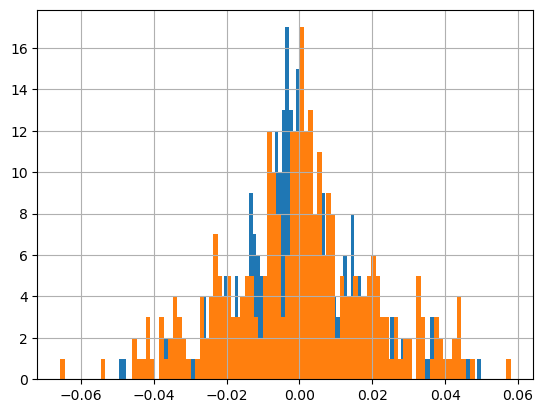

In [1825]:
x_c = df['x'].shift(1)-df['v_fw']/df['omega_calc']*np.sin(df['theta'].shift(1))
y_c = df['y'].shift(1)+df['v_fw']/df['omega_calc']*np.cos(df['theta'].shift(1))
x_new = x_c + df['v_fw']/df['omega_calc']*np.sin(df['theta'].shift(1)+df['omega_calc']*new_timestep)
y_new = y_c - df['v_fw']/df['omega_calc']*np.cos(df['theta'].shift(1)+df['omega_calc']*new_timestep)
x_error = x_new - df['x']
y_error = y_new - df['y']
(x_error).hist(bins=100)
(y_error).hist(bins=100)
print(np.abs(df['vx']).mean(), np.abs(x_error).max()/new_timestep)
print(np.abs(df['vy']).mean(), np.abs(y_error).max()/new_timestep)


Relative velocities model validation:

<Axes: >

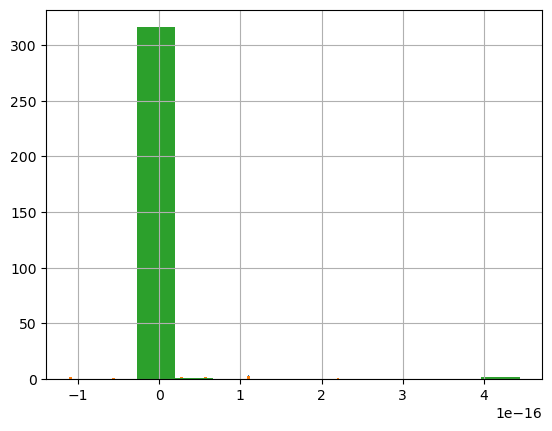

In [1826]:
x_new = df['x'].shift(1) + df['v_fw_calc']*np.cos(df['theta'].shift(1))*new_timestep - df['v_n_calc']*np.sin(df['theta'].shift(1))*new_timestep
y_new = df['y'].shift(1) + df['v_fw_calc']*np.sin(df['theta'].shift(1))*new_timestep + df['v_n_calc']*np.cos(df['theta'].shift(1))*new_timestep
theta_new = df['theta'].shift(1) + df['omega_calc']*new_timestep
theta_new.loc[theta_new < -np.pi] = theta_new.loc[theta_new < -np.pi] + 2*np.pi
theta_new.loc[theta_new > np.pi] = theta_new.loc[theta_new > np.pi] - 2*np.pi
x_error = x_new - df['x']
y_error = y_new - df['y']
theta_error = theta_new - df['theta']
(x_error).hist(bins=100)
(y_error).hist(bins=100)
(theta_error).hist()

array([[<Axes: title={'center': 'omega_calc'}>]], dtype=object)

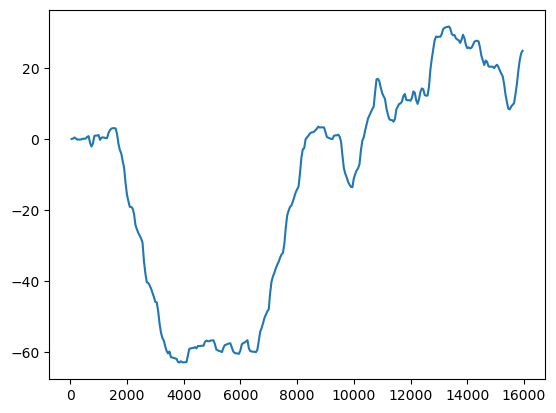

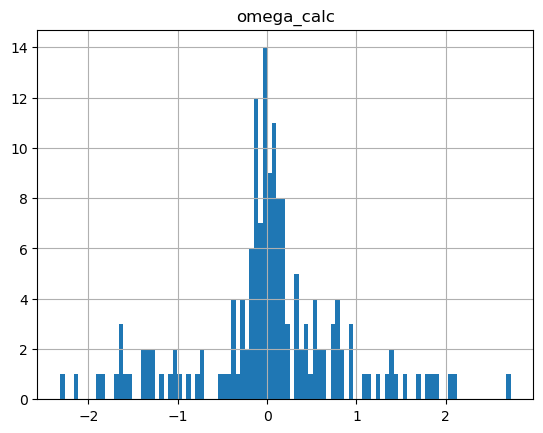

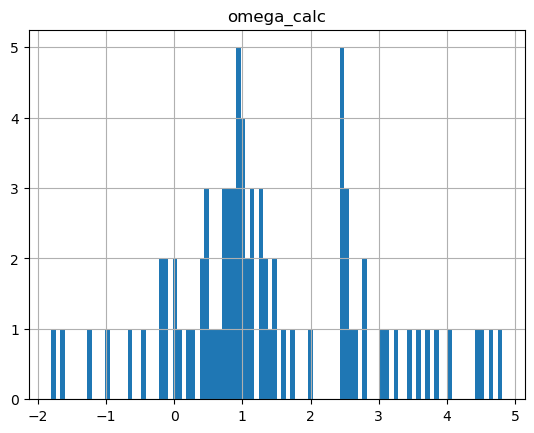

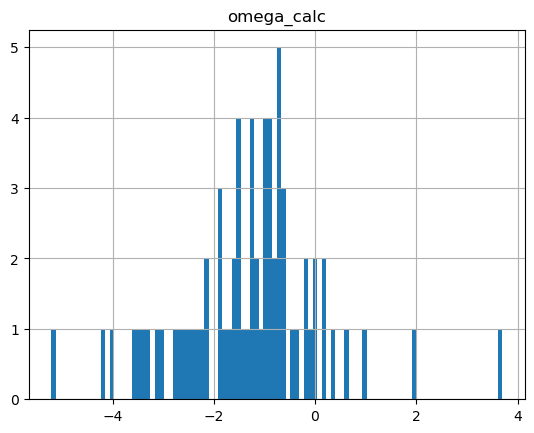

In [1827]:
df['omega_calc'].cumsum().plot()
forward_df.hist(column='omega_calc', bins=100)
left_df.hist(column='omega_calc', bins=100)
right_df.hist(column='omega_calc', bins=100)

In [1828]:
def mask_commmands(df, column):
    fw = np.ma.masked_where(df['command'] != 'FORWARD', df[column])
    left = np.ma.masked_where(df['command'] != 'LEFT', df[column])
    right = np.ma.masked_where(df['command'] != 'RIGHT', df[column])
    return fw, left, right

def mask_contact(df, column):
    left_only = np.ma.masked_where(df['contact_left'] == 1 & df['contact_right'] == 0, df[column])
    right_only = np.ma.masked_where(df['contact_left'] == 0 & df['contact_right'] == 1, df[column])
    both = np.ma.masked_where(df['contact_left'] == 1 & df['contact_right'] == 1, df[column])
    return left_only, right_only, both

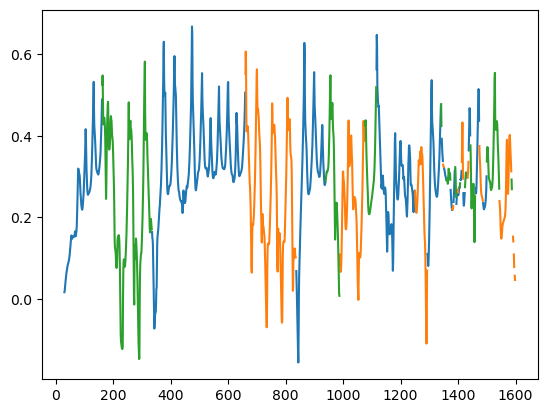

In [1967]:
v_fw_fw, v_fw_left, v_fw_right = mask_commmands(df, 'v_fw_calc')
plt.plot(v_fw_fw, label='forward')
plt.plot(v_fw_left, label='left')
plt.plot(v_fw_right, label='right')

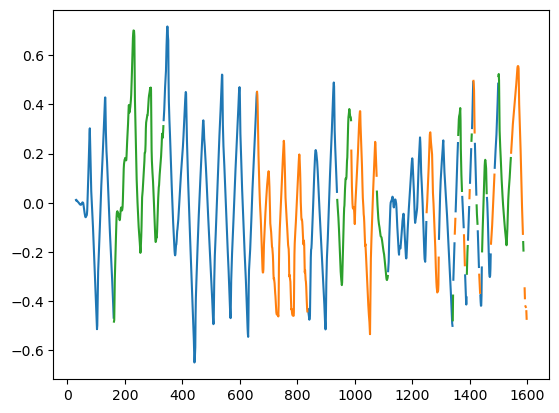

In [1968]:
v_n_fw, v_n_left, v_n_right = mask_commmands(df, 'v_n_calc')
plt.plot(v_n_fw, label='forward')
plt.plot(v_n_left, label='left')
plt.plot(v_n_right, label='right')

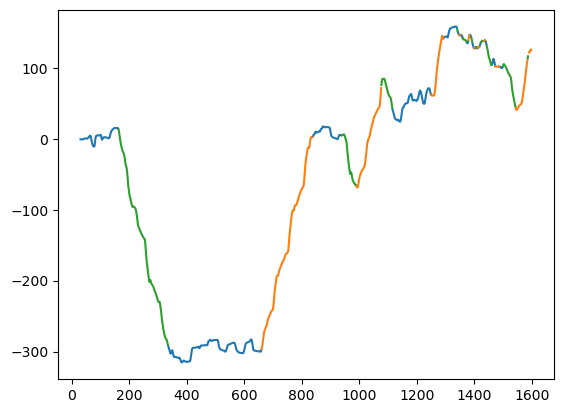

In [1969]:
tmp = pd.DataFrame()
tmp['command'] = df['command']
tmp['cumsum'] = df['omega_calc'].cumsum()
theta_fw, theta_left, theta_right = mask_commmands(tmp, 'cumsum')
plt.plot(theta_fw)
plt.plot(theta_left)
plt.plot(theta_right)

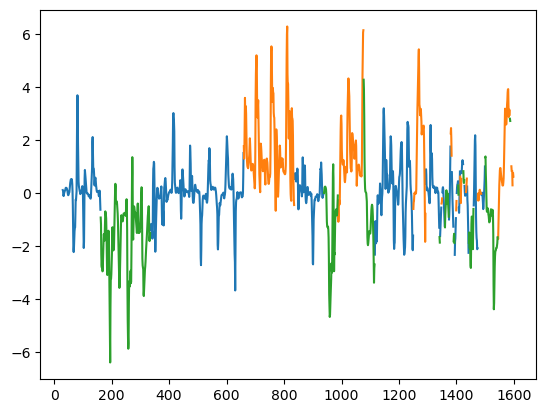

In [1970]:
omega_calc_fw, omega_calc_left, omega_calc_right = mask_commmands(df, 'omega_calc')
plt.plot(omega_calc_fw)
plt.plot(omega_calc_left)
plt.plot(omega_calc_right)

Motion model identification:

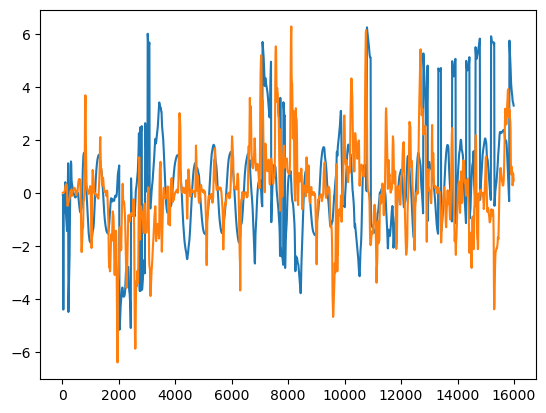

In [1971]:
def get_real_vels(df):
    num = (df['x_prev']-df['x'])*np.cos(df['theta_prev']) + (df['y_prev']-df['y'])*np.sin(df['theta_prev'])
    den = (df['y_prev']-df['y'])*np.cos(df['theta_prev']) - (df['x_prev']-df['x'])*np.sin(df['theta_prev'])
    mu = 0.5*num/den
    x_c = 0.5*(df['x_prev']+df['x']) + mu * (df['y_prev'] - df['y'])
    y_c = 0.5*(df['y_prev']+df['y']) + mu * (df['x'] - df['x_prev'])
    r = np.sqrt((df['x']-x_c)**2 + (df['y']-y_c)**2)
    delta_theta = np.arctan2(df['y']-y_c, df['x']-x_c) - np.arctan2(df['y_prev']-y_c, df['x_prev']-x_c)
    debug = pd.DataFrame()
    debug['1'] = np.arctan2(df['y']-y_c, df['x']-x_c)
    debug['2'] = np.arctan2(df['y_prev']-y_c, df['x_prev']-x_c)
    debug['r'] = r
    debug['xc'] = x_c
    debug['yc'] = y_c
    debug['mu'] = mu
    debug['num'] = num
    debug['den'] = den
    debug['delta_theta'] = delta_theta
    delta_dist = r * delta_theta
    v_real = delta_dist/new_timestep
    omega_real = delta_theta/new_timestep
    gamma_real = (df['theta'] - df['theta_prev'])/new_timestep
    return v_real, omega_real, gamma_real, debug

v_real, omega_real, gamma_real, debug = get_real_vels(df)

plt.plot(debug['delta_theta'])

#plt.plot(omega_real)
plt.plot(df['omega_calc'])

# plt.plot(np.abs(v_real))
# plt.plot(df['v_mod'])
# plt.ylim(0, 1)

# (df['v_mod'] - v_real).hist(bins=100)
# (df['omega_calc'] - omega_real).hist(bins=100)
# v_real.hist(bins=100)
# plt.figure()
# omega_real.hist(bins=100)

In [2038]:
import statsmodels.regression.linear_model as sm
forward_df['ones'] = 1
fw_v_fw_model = sm.OLS(forward_df['v_fw_calc'], exog=forward_df[['v_fw_calc_prev', 'v_fw_calc_prev_prev', 'ones']]).fit()
fw_v_n_model = sm.OLS(forward_df['v_n_calc'], exog=forward_df[['v_n_calc_prev', 'v_n_calc_prev_prev', 'ones']]).fit()
fw_omega_model = sm.OLS(forward_df['omega_calc'], exog=forward_df[['omega_calc_prev', 'omega_calc_prev_prev', 'ones']]).fit()

left_df['ones'] = 1
left_v_fw_model = sm.OLS(left_df['v_fw_calc'], exog=left_df[['v_fw_calc_prev', 'v_fw_calc_prev_prev', 'ones']]).fit()
left_v_n_model = sm.OLS(left_df['v_n_calc'], exog=left_df[['v_n_calc_prev', 'v_n_calc_prev_prev', 'ones']]).fit()
left_omega_model = sm.OLS(left_df['omega_calc'], exog=left_df[['omega_calc_prev', 'omega_calc_prev_prev', 'ones']]).fit()

right_df['ones'] = 1
right_v_fw_model = sm.OLS(right_df['v_fw_calc'], exog=right_df[['v_fw_calc_prev', 'v_fw_calc_prev_prev', 'ones']]).fit()
right_v_n_model = sm.OLS(right_df['v_n_calc'], exog=right_df[['v_n_calc_prev', 'v_n_calc_prev_prev', 'ones']]).fit()
right_omega_model = sm.OLS(right_df['omega_calc'], exog=right_df[['omega_calc_prev', 'omega_calc_prev_prev', 'ones']]).fit()

/tmp/ipykernel_573226/3236137724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_df['ones'] = 1
/tmp/ipykernel_573226/3236137724.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['ones'] = 1
/tmp/ipykernel_573226/3236137724.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [1974]:
import statsmodels.regression.linear_model as sm
forward_df['ones'] = 1
fw_v_fw_model = sm.OLS(forward_df['v_fw_calc'], exog=forward_df[['v_fw_calc_prev', 'ones']]).fit()
fw_v_n_model = sm.OLS(forward_df['v_n_calc'], exog=forward_df[['v_n_calc_prev', 'ones']]).fit()
fw_omega_model = sm.OLS(forward_df['omega_calc'], exog=forward_df[['omega_calc_prev', 'ones']]).fit()

left_df['ones'] = 1
left_v_fw_model = sm.OLS(left_df['v_fw_calc'], exog=left_df[['v_fw_calc_prev', 'ones']]).fit()
left_v_n_model = sm.OLS(left_df['v_n_calc'], exog=left_df[['v_n_calc_prev', 'ones']]).fit()
left_omega_model = sm.OLS(left_df['omega_calc'], exog=left_df[['omega_calc_prev', 'ones']]).fit()

right_df['ones'] = 1
right_v_fw_model = sm.OLS(right_df['v_fw_calc'], exog=right_df[['v_fw_calc_prev',  'ones']]).fit()
right_v_n_model = sm.OLS(right_df['v_n_calc'], exog=right_df[['v_n_calc_prev', 'ones']]).fit()
right_omega_model = sm.OLS(right_df['omega_calc'], exog=right_df[['omega_calc_prev', 'ones']]).fit()

/tmp/ipykernel_573226/2595531972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_df['ones'] = 1
/tmp/ipykernel_573226/2595531972.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['ones'] = 1
/tmp/ipykernel_573226/2595531972.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

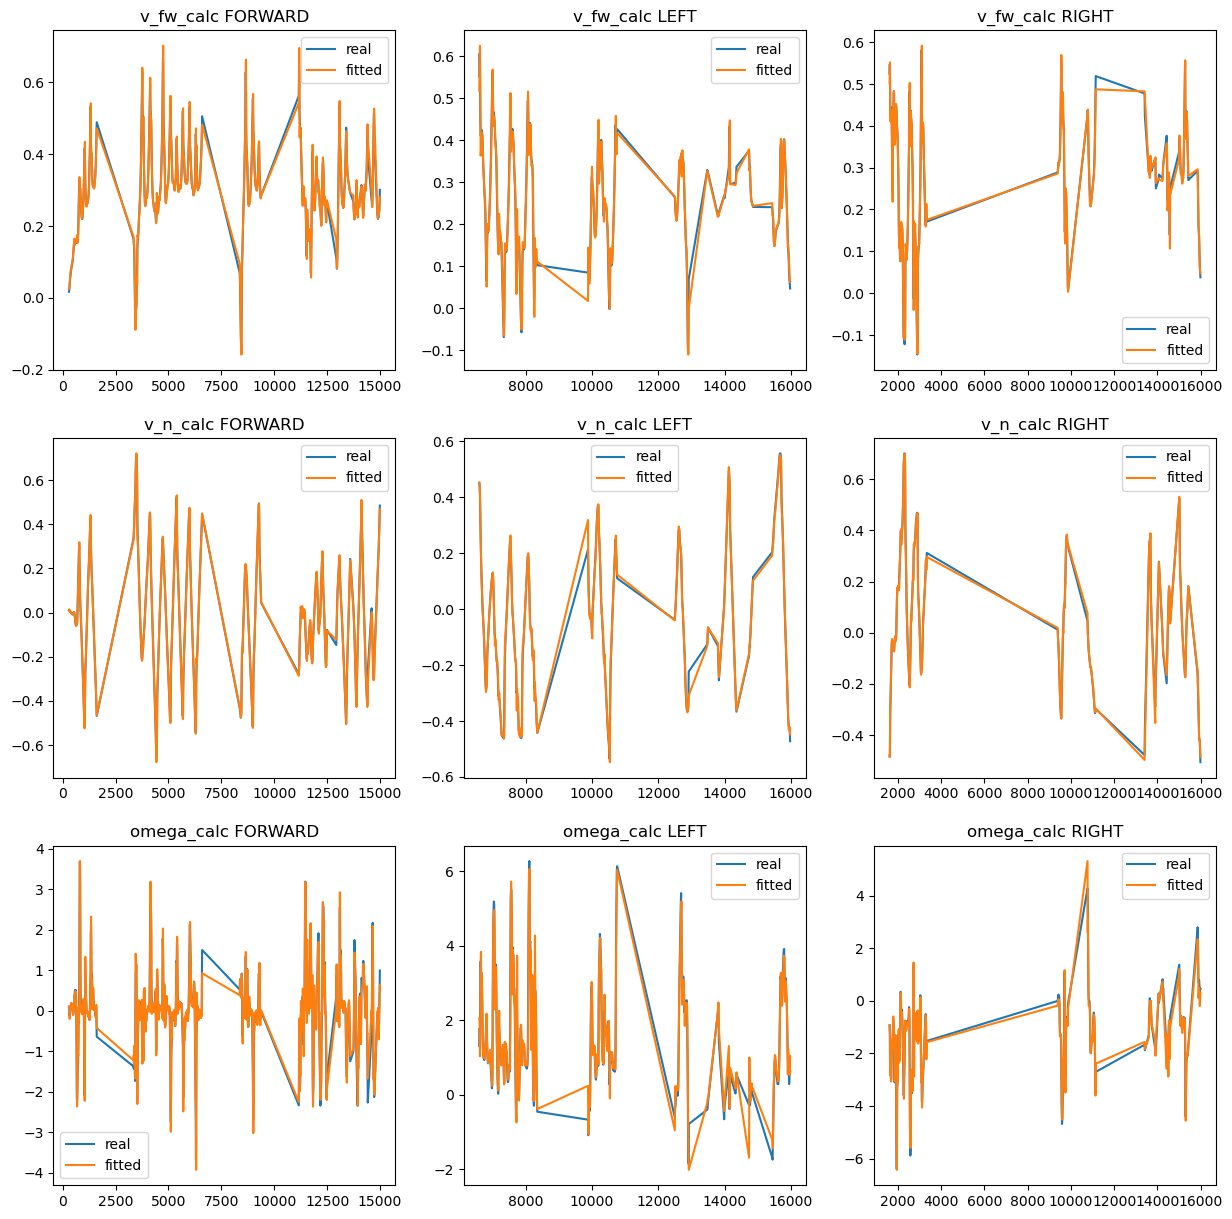

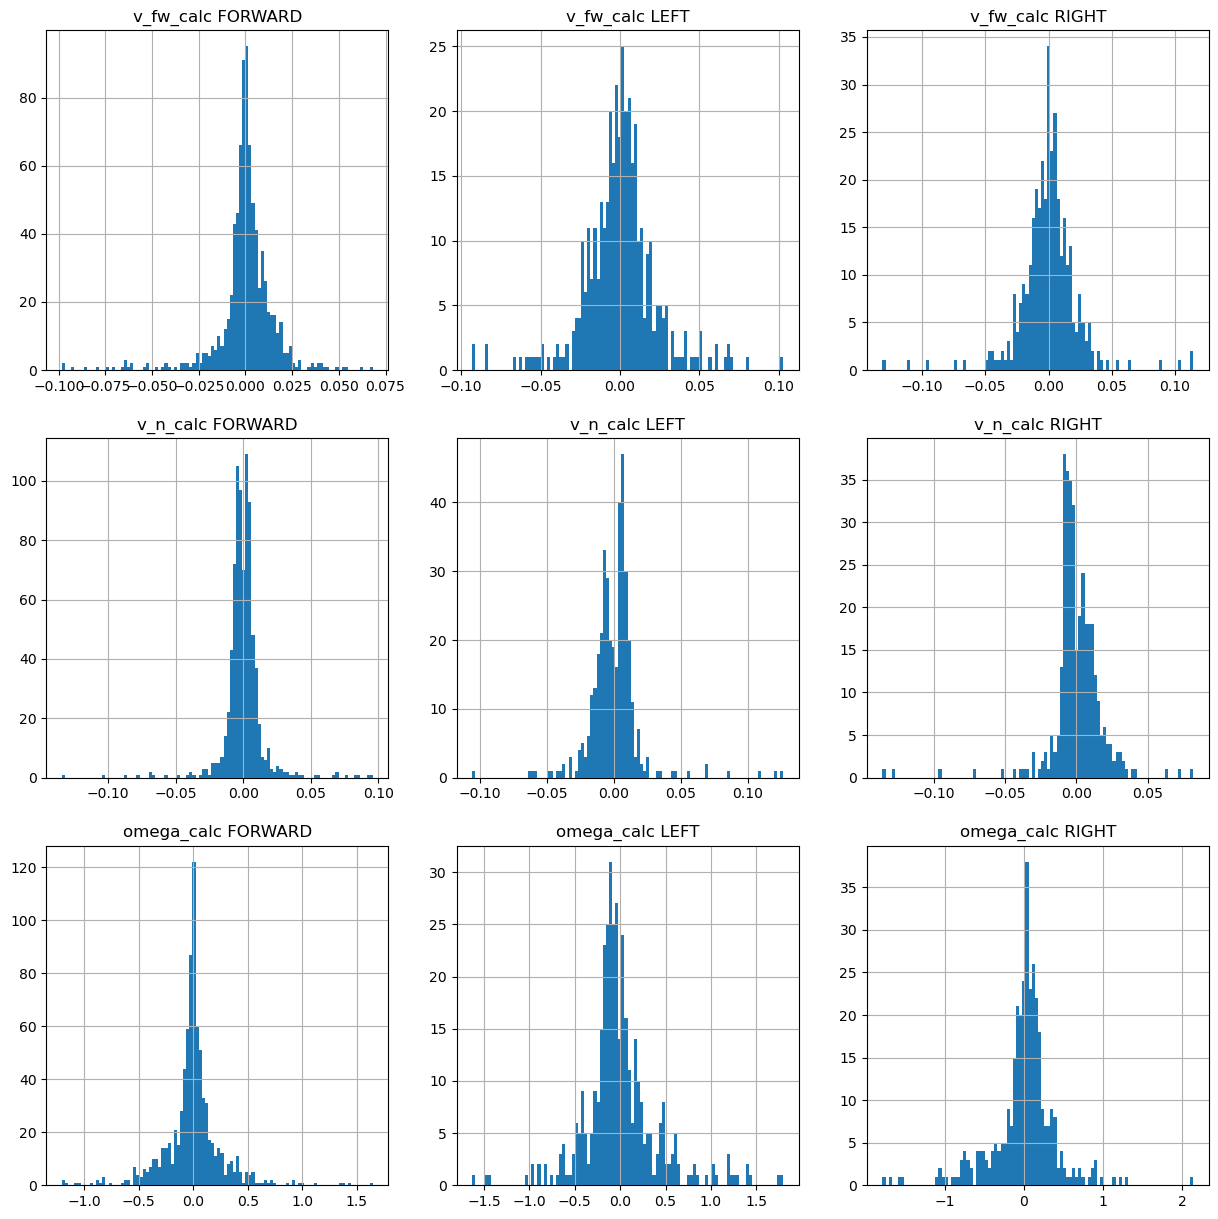

In [2039]:
import statsmodels.api as sm_api
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

models = {
    'v_fw_calc': {
        'FORWARD': {
            'model': fw_v_fw_model,
            'data': forward_df['v_fw_calc']
        },
        'LEFT': {
            'model': left_v_fw_model,
            'data': left_df['v_fw_calc']
        },
        'RIGHT': {
            'model': right_v_fw_model,
            'data': right_df['v_fw_calc']
        }
    },
    'v_n_calc': {
        'FORWARD': {
            'model': fw_v_n_model,
            'data': forward_df['v_n_calc']
        },
        'LEFT': {
            'model': left_v_n_model,
            'data': left_df['v_n_calc']
        },
        'RIGHT': {
            'model': right_v_n_model,
            'data': right_df['v_n_calc']
        }
    },
    'omega_calc': {
        'FORWARD': {
            'model': fw_omega_model,
            'data': forward_df['omega_calc']
        },
        'LEFT': {
            'model': left_omega_model,
            'data': left_df['omega_calc']
        },
        'RIGHT': {
            'model': right_omega_model,
            'data': right_df['omega_calc']
        }
    }
}

for i, (key, value) in enumerate(models.items()):
    for j, (policy, data) in enumerate(value.items()):
        ax[i, j].plot(data['data'], label='data')
        ax[i, j].plot(data['model'].fittedvalues, label='model')
        ax[i, j].legend(['real', 'fitted'])
        ax[i, j].set_title(f"{key} {policy}")

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, (key, value) in enumerate(models.items()):
    for j, (policy, data) in enumerate(value.items()):
        data['model'].resid.hist(bins=100, ax=ax[i, j])
        ax[i, j].set_title(f"{key} {policy}")

In [2453]:
print("Forward vector models")
print("FORWARD")
print(fw_v_fw_model.params)
print(fw_v_n_model.resid.var())
print("LEFT")
print(left_v_fw_model.params)
print(fw_v_n_model.resid.var())
print("RIGHT")
print(right_v_fw_model.params)
print(fw_v_n_model.resid.var())

print("Normal vector models")
print("FORWARD")
print(fw_v_n_model.params)
print(fw_v_n_model.resid.var())
print("LEFT")
print(left_v_n_model.params)
print(fw_v_n_model.resid.var())
print("RIGHT")
print(right_v_n_model.params)
print(fw_v_n_model.resid.var())

print("Omega models")
print("FORWARD")
print(fw_omega_model.params)
print(fw_v_n_model.resid.var())
print("LEFT")
print(left_omega_model.params)
print(fw_v_n_model.resid.var())
print("RIGHT")
print(right_omega_model.params)
print(fw_v_n_model.resid.var())


Forward vector models
FORWARD
v_fw_calc_prev         1.664696
v_fw_calc_prev_prev   -0.695627
ones                   0.009790
dtype: float64
0.0002329543323488562
LEFT
v_fw_calc_prev         1.619293
v_fw_calc_prev_prev   -0.669814
ones                   0.012417
dtype: float64
0.0002329543323488562
RIGHT
v_fw_calc_prev         1.626568
v_fw_calc_prev_prev   -0.662228
ones                   0.008834
dtype: float64
0.0002329543323488562
Normal vector models
FORWARD
v_n_calc_prev         1.868364
v_n_calc_prev_prev   -0.881977
ones                  0.000059
dtype: float64
0.0002329543323488562
LEFT
v_n_calc_prev         1.813986
v_n_calc_prev_prev   -0.831571
ones                 -0.001673
dtype: float64
0.0002329543323488562
RIGHT
v_n_calc_prev         1.780212
v_n_calc_prev_prev   -0.799177
ones                  0.001515
dtype: float64
0.0002329543323488562
Omega models
FORWARD
omega_calc_prev         1.546241
omega_calc_prev_prev   -0.675672
ones                    0.004531
dtype: flo

In [2493]:
import pickle
fw_coeffs = pd.concat([fw_v_fw_model.params.rename("v_fw"), fw_v_n_model.params.rename("v_n"), fw_omega_model.params.rename("omega")], axis=1).T
ones = fw_coeffs.pop('ones')
fw_coeffs['ones'] = ones
fw_coeffs = np.nan_to_num(fw_coeffs.to_numpy())
fw_cov = np.diag([fw_v_fw_model.resid.var(), fw_v_n_model.resid.var(), fw_omega_model.resid.var()])

left_coeffs = pd.concat([left_v_fw_model.params.rename("v_fw"), left_v_n_model.params.rename("v_n"), left_omega_model.params.rename("omega")], axis=1).T
ones = left_coeffs.pop('ones')
left_coeffs['ones'] = ones
print(left_coeffs)
left_coeffs.loc['v_fw', 'ones'] = 0.008834
print(left_coeffs)
left_coeffs = np.nan_to_num(left_coeffs.to_numpy())
left_cov = np.diag([left_v_fw_model.resid.var(), left_v_n_model.resid.var(), left_omega_model.resid.var()])


right_coeffs = pd.concat([right_v_fw_model.params.rename("v_fw"), right_v_n_model.params.rename("v_n"), right_omega_model.params.rename("omega")], axis=1).T
ones = right_coeffs.pop('ones')
right_coeffs['ones'] = ones
right_coeffs = np.nan_to_num(right_coeffs.to_numpy())
right_cov = np.diag([right_v_fw_model.resid.var(), right_v_n_model.resid.var(), right_omega_model.resid.var()])
models = {
    'FORWARD': {
        'coeffs': fw_coeffs,
        'cov': fw_cov
    },
    'LEFT': {
        'coeffs': left_coeffs,
        'cov': left_cov
    },
    'RIGHT': {
        'coeffs': right_coeffs,
        'cov': right_cov
    }
}
data_dict = {
    'models': models,
    'timestep': new_timestep
}
with open(experiment_folder / 'models_ols_fno.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

       v_fw_calc_prev  v_fw_calc_prev_prev  v_n_calc_prev  v_n_calc_prev_prev  \
v_fw         1.619293            -0.669814            NaN                 NaN   
v_n               NaN                  NaN       1.813986           -0.831571   
omega             NaN                  NaN            NaN                 NaN   

       omega_calc_prev  omega_calc_prev_prev      ones  
v_fw               NaN                   NaN  0.012417  
v_n                NaN                   NaN -0.001673  
omega         1.496869             -0.599694  0.161192  
       v_fw_calc_prev  v_fw_calc_prev_prev  v_n_calc_prev  v_n_calc_prev_prev  \
v_fw         1.619293            -0.669814            NaN                 NaN   
v_n               NaN                  NaN       1.813986           -0.831571   
omega             NaN                  NaN            NaN                 NaN   

       omega_calc_prev  omega_calc_prev_prev      ones  
v_fw               NaN                   NaN  0.008834  
v_n     

How to use the model:

[9.78436821e-03 4.63055306e-05 4.12880523e-03]
0.009785438936048014
[ 0.00880303 -0.00167054  0.16151291]
0.008962675328900977
[ 0.00885242  0.00154034 -0.16737995]
0.00898716438571541


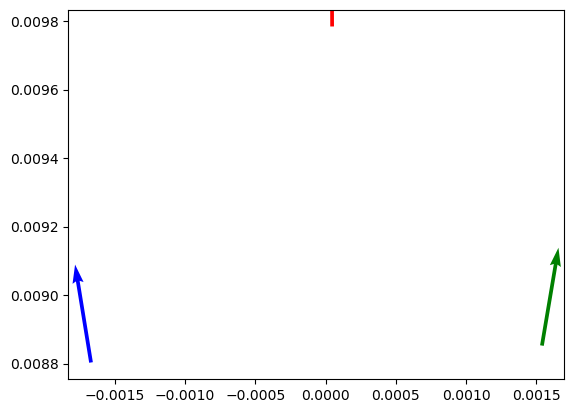

In [2523]:
def scatter_plot_model(model_name, color='r'):
    v_fw_old = 0.0
    v_n_old = 0.0
    omega_old = 0.0
    v_fw_old_old = 0.0
    v_n_old_old = 0.0
    omega_old_old = 0.0
    regressors =  np.array([v_fw_old, v_fw_old_old, v_n_old, v_n_old_old, omega_old, omega_old_old, 1])
    #regressors =  np.array([v_fw_old, v_n_old, omega_old, 1])
    mean = np.matmul(models[model_name]['coeffs'], regressors)
    sample_vels = np.random.multivariate_normal(mean, models[model_name]['cov']/10000, 100)
    print(sample_vels.mean(axis=0))
    x_old = 0.0
    y_old = 0.0
    theta_old = np.pi/2
    x = x_old + sample_vels[:,0]*np.cos(theta_old)*new_timestep*50 + sample_vels[:,1]*np.sin(theta_old)*new_timestep*50
    y = y_old + sample_vels[:,0]*np.sin(theta_old)*new_timestep*50 - sample_vels[:,1]*np.cos(theta_old)*new_timestep*50
    theta = theta_old + sample_vels[:,2]*new_timestep*50
    print(np.sqrt(x**2 + y**2).mean())
    mean_theta = theta.mean()
    mean_x = x.mean()
    mean_y = y.mean()
    plt.quiver(mean_x, mean_y, np.cos(mean_theta), np.sin(mean_theta), color=color, scale=5)
scatter_plot_model('FORWARD', color='r')
scatter_plot_model('LEFT', color='b')
scatter_plot_model('RIGHT', color='g')

# Regression with ARIMAX

In [273]:
# Load the data
experiment_folder = pathlib.Path(os.path.abspath('')).parent / "experiments" / "h1_teleop_experiments" / "forward_only"
data = pd.read_csv(experiment_folder / "data.csv")

data['delta_x'] = data['x'].diff()
data['delta_y'] = data['y'].diff()
data['delta_theta'] = data['theta'].diff()
data['v_mod'] = np.sqrt(data['vx']**2 + data['vy']**2)
data['v_ang'] = np.arctan2(data['vy'], data['vx'])

data['prev_vx'] = data['vx'].shift(1)
data['prev_vy'] = data['vy'].shift(1)
data['prev_omega'] = data['omega'].shift(1)
data['prev_v_mod'] = data['v_mod'].shift(1)
data['prev_v_ang'] = data['v_ang'].shift(1)

forward_policy = data.loc[data['command'] == 'FORWARD']
right_policy = data.loc[data['command'] == 'RIGHT']
left_policy = data.loc[data['command'] == 'LEFT']

In [278]:
forward_policy

,time,command,x,y,theta,vx,vy,omega,contact_left,contact_right,delta_x,delta_y,delta_theta,v_mod,v_ang,prev_vx,prev_vy,prev_omega,prev_v_mod,prev_v_ang
523,1.046,FORWARD,0.025364,-0.000410,0.076385,0.084153,-0.004861,0.085373,True,True,0.000168,-9.721627e-06,0.000173,0.084294,-0.057697,0.084299,-0.004959,0.088948,0.084444,-0.058755
524,1.048,FORWARD,0.025532,-0.000419,0.076552,0.084009,-0.004760,0.082023,True,True,0.000168,-9.519600e-06,0.000166,0.084144,-0.056598,0.084153,-0.004861,0.085373,0.084294,-0.057697
525,1.050,FORWARD,0.025700,-0.000429,0.076712,0.083865,-0.004656,0.078878,True,True,0.000168,-9.311455e-06,0.000160,0.083994,-0.055457,0.084009,-0.004760,0.082023,0.084144,-0.056598
526,1.052,FORWARD,0.025867,-0.000438,0.076866,0.083722,-0.004549,0.075919,True,True,0.000167,-9.097412e-06,0.000154,0.083845,-0.054278,0.083865,-0.004656,0.078878,0.083994,-0.055457
527,1.054,FORWARD,0.026034,-0.000447,0.077015,0.083579,-0.004439,0.073129,True,True,0.000167,-8.877707e-06,0.000149,0.083696,-0.053060,0.083722,-0.004549,0.075919,0.083845,-0.054278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,15.990,FORWARD,3.867407,-3.230596,-0.589299,0.505221,-0.002963,-0.112744,False,True,0.001010,-5.926675e-06,-0.000222,0.505230,-0.005865,0.501467,-0.003666,-0.112721,0.501481,-0.007310
7996,15.992,FORWARD,3.868425,-3.230600,-0.589522,0.508990,-0.002285,-0.112574,False,True,0.001018,-4.570701e-06,-0.000223,0.508995,-0.004490,0.505221,-0.002963,-0.112744,0.505230,-0.005865
7997,15.994,FORWARD,3.869451,-3.230604,-0.589745,0.512774,-0.001632,-0.112213,False,True,0.001026,-3.263409e-06,-0.000223,0.512777,-0.003182,0.508990,-0.002285,-0.112574,0.508995,-0.004490
7998,15.996,FORWARD,3.870484,-3.230606,-0.589968,0.516576,-0.001003,-0.111662,False,True,0.001033,-2.005010e-06,-0.000223,0.516577,-0.001941,0.512774,-0.001632,-0.112213,0.512777,-0.003182


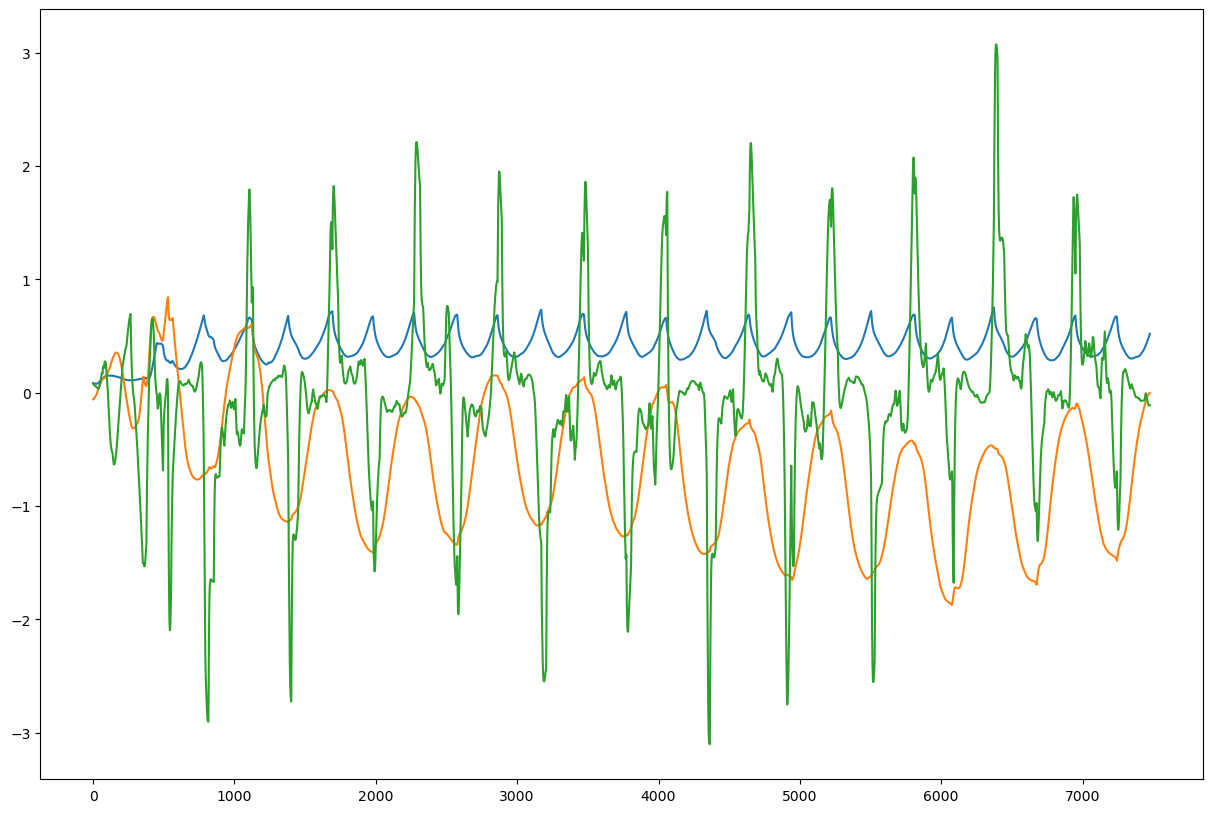

In [235]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(len(forward_policy['vx'])), forward_policy['v_mod'])
plt.plot(np.arange(len(forward_policy['vx'])), forward_policy['v_ang'])
plt.plot(np.arange(len(forward_policy['vx'])), forward_policy['omega'])

Check for autocorrelation

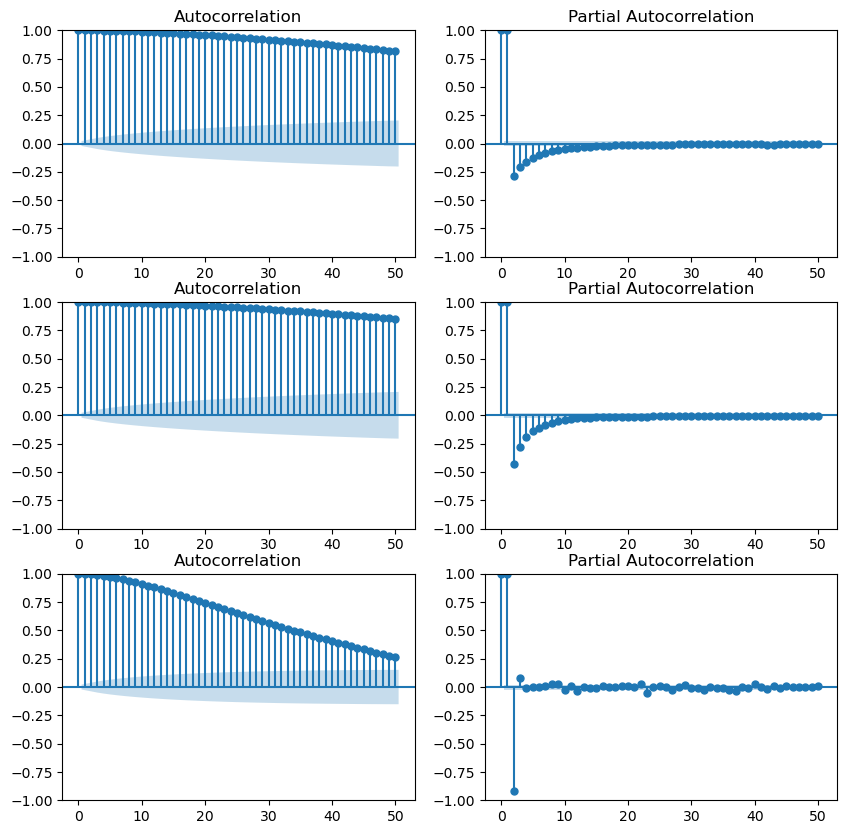

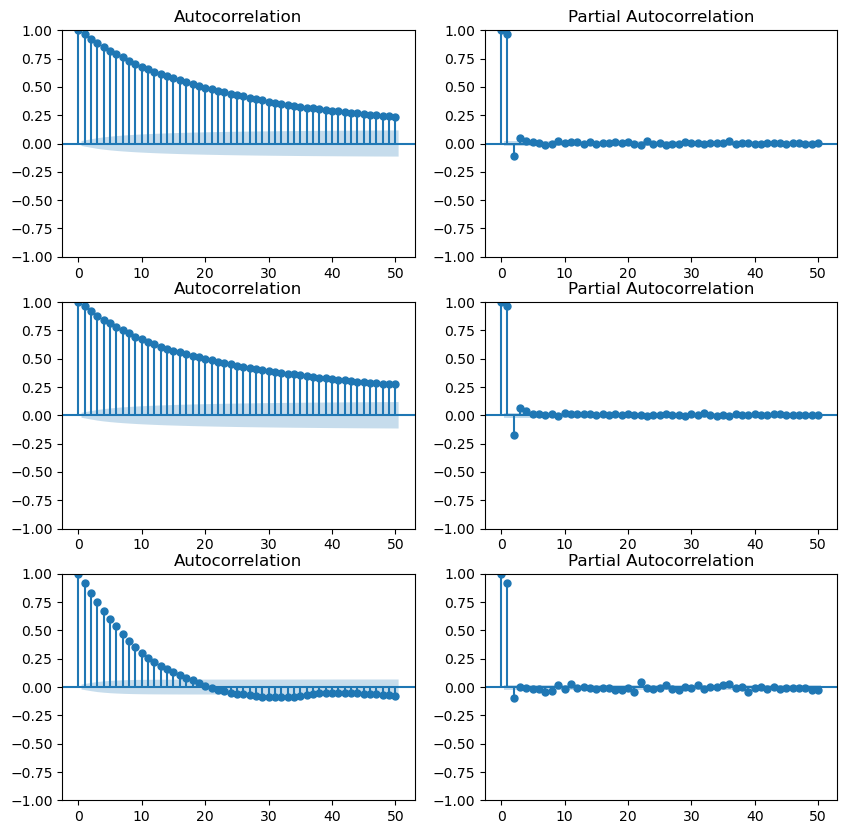

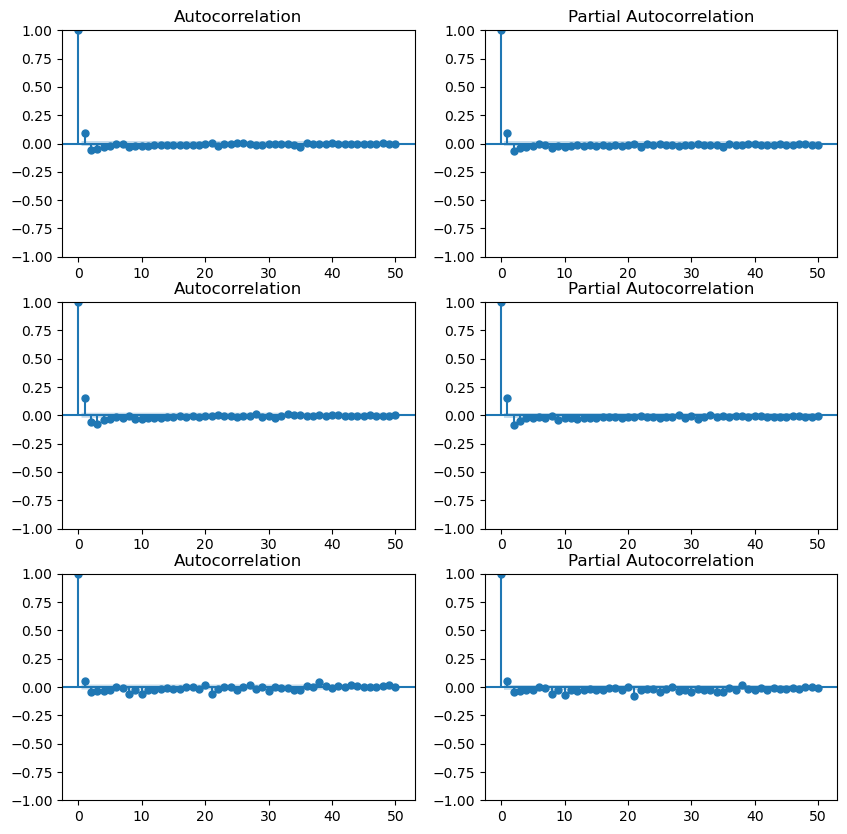

In [222]:
import numpy as np
import statsmodels.graphics.tsaplots as tsaplots

def plot_acf_pacf(data, labels, lags=50):
    fig, ax = plt.subplots(len(labels), 2, figsize=(10, 10))
    for i, label in enumerate(labels):
        _ = tsaplots.plot_acf(data[label], lags=lags, ax=ax[i,0])
        _ = tsaplots.plot_pacf(data[label], lags=lags, ax=ax[i,1])

nlags = 50
labels = ['vx', 'vy', 'omega']
plot_acf_pacf(data, labels, lags=nlags)


diff_data = data[['vx', 'vy', 'omega']].diff()
diff_data = diff_data.dropna()
plot_acf_pacf(diff_data, labels, lags=nlags)

diff_diff_data = diff_data.diff()
diff_diff_data = diff_diff_data.dropna()
plot_acf_pacf(diff_diff_data, labels, lags=nlags)

In [361]:
#Augmented Dickey–Fuller test:
from statsmodels.tsa.stattools import adfuller
adfuller_labels = ['adf', 'pvalue', 'usedlag','nobs','critical values','icbest']
for label in labels:
    print(label)
    res = adfuller(data[label])
    for x in list(zip(adfuller_labels, res)):
        print(x[0], ":", x[1])

vx
adf : -4.821138270878075
pvalue : 4.9542061986541755e-05
usedlag : 4
nobs : 7995
critical values : {'1%': -3.431168186467157, '5%': -2.8619015797632765, '10%': -2.566962464208204}
icbest : -92819.46008500573
vy
adf : -4.31148028774624
pvalue : 0.00042431169770233354
usedlag : 4
nobs : 7995
critical values : {'1%': -3.431168186467157, '5%': -2.8619015797632765, '10%': -2.566962464208204}
icbest : -92350.08982365005
omega
adf : -9.525195620473545
pvalue : 2.990829721378308e-16
usedlag : 36
nobs : 7963
critical values : {'1%': -3.4311714754806224, '5%': -2.861903033070527, '10%': -2.5669632378194773}
icbest : -45411.804661698596


In [216]:
exog_policy = pd.DataFrame([data['command'] == 'FORWARD', data['command'] == 'LEFT', data['command'] == 'RIGHT'], index=['FORWARD', 'LEFT', 'RIGHT']).T
exog_policy = exog_policy.astype(int)

policy_switch = exog_policy.diff()
# with pd.option_context('display.max_rows', 10000):
#     display(policy_switch.head(10000))

time_skips = forward_policy['time'] - forward_policy['time'].shift(1) > 0.003
vx_skip = forward_policy[time_skips]['prev_vx'] - forward_policy['vx'].shift(1)[time_skips]
vx_skip.name = 'vx_skip'
forward_policy_augmented = pd.merge(forward_policy, vx_skip, left_index=True, right_index=True, how='left')
forward_policy_augmented['vx_skip'] = forward_policy_augmented['vx_skip'].fillna(0)
forward_policy_augmented['contact_both'] = forward_policy_augmented['contact_left'] & forward_policy_augmented['contact_right']
forward_policy_augmented['contact_left_only'] = forward_policy_augmented['contact_left'] & ~forward_policy_augmented['contact_right']
forward_policy_augmented['contact_right_only'] = ~forward_policy_augmented['contact_left'] & forward_policy_augmented['contact_right']
forward_policy_augmented['contact_both'] = forward_policy_augmented['contact_both'].astype(int)
forward_policy_augmented['contact_left'] = forward_policy_augmented['contact_left'].astype(int)
forward_policy_augmented['contact_right'] = forward_policy_augmented['contact_right'].astype(int)
forward_policy_augmented['contact_right_only'] = forward_policy_augmented['contact_right_only'].astype(int)
forward_policy_augmented['contact_left_only'] = forward_policy_augmented['contact_left_only'].astype(int)
forward_policy_augmented['contact_left_event'] = forward_policy_augmented['contact_left'].diff().fillna(0).astype(int)
forward_policy_augmented['contact_right_event'] = forward_policy_augmented['contact_right'].diff().fillna(0).astype(int)
forward_policy_augmented['contact_both_event'] = forward_policy_augmented['contact_both'].diff().fillna(0).astype(int)

In [218]:
fw_arima = SARIMAX(forward_policy_augmented['vx'], order=(2,1,2), exog=forward_policy_augmented[['prev_vy', 'prev_omega', 'contact_left_only', 'contact_right_only', 'contact_both']]).fit(disp=False)
display(fw_arima.summary())
fw_arima.plot_diagnostics(figsize=(15, 12))

SyntaxError: invalid syntax (3962442731.py, line 1)

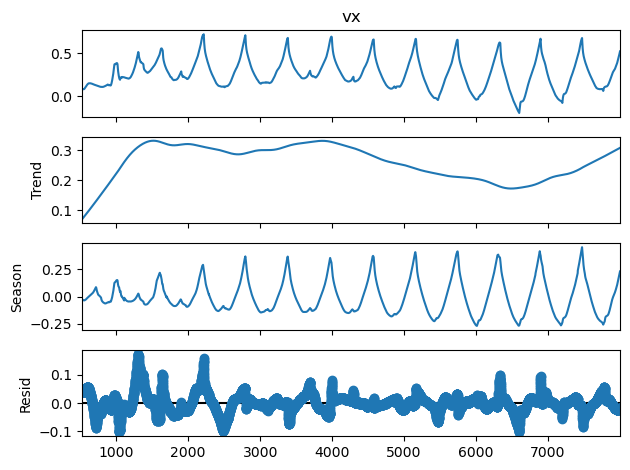

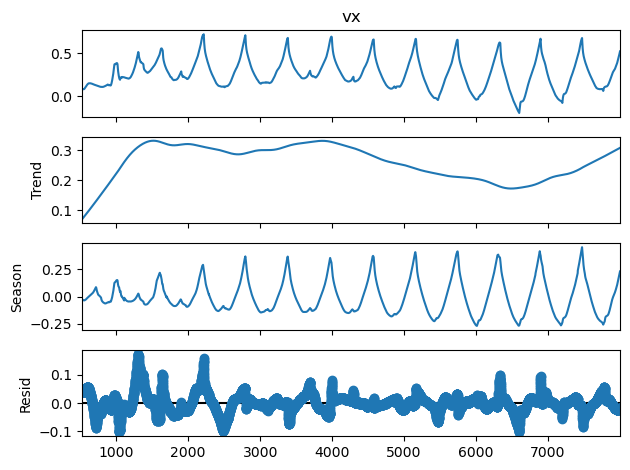

In [220]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.seasonal import MSTL, STL
STL(forward_policy_augmented['vx'][0:], period=588).fit().plot()

In [221]:
np.min(abs_resid), np.max(abs_resid), np.mean(abs_resid), np.std(abs_resid)

NameError: name 'abs_resid' is not defined

(3.8673037552720835e-08,
 0.08492805408746884,
 0.0001897115687158743,
 0.0012294052193279452)

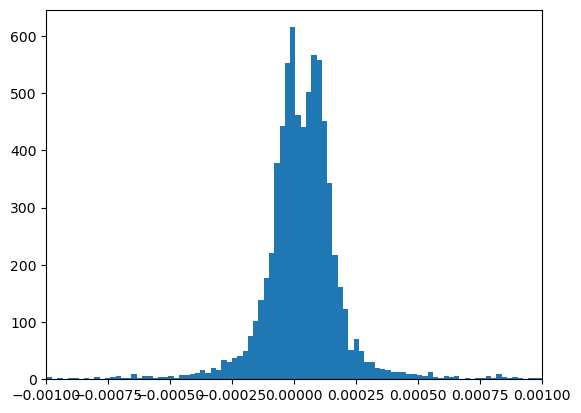

In [422]:
plt.figure()
plt.hist(fw_arima.resid, bins=5000)
plt.xlim(-0.001, 0.001)
abs_resid = np.abs(fw_arima.resid)


# Regression with VARMAX

In [370]:

def load_data(name):
    experiment_folder = pathlib.Path(os.path.abspath('')).parent / "experiments" / "h1_teleop_experiments" / name
    data = pd.read_csv(experiment_folder / "data.csv")

    data['delta_x'] = data['x'].diff()
    data['delta_y'] = data['y'].diff()
    data['delta_theta'] = data['theta'].diff()
    data['v_mod'] = np.sqrt(data['vx']**2 + data['vy']**2)
    data['v_ang'] = np.arctan2(data['vy'], data['vx'])

    data['prev_vx'] = data['vx'].shift(1)
    data['prev_vy'] = data['vy'].shift(1)
    data['prev_omega'] = data['omega'].shift(1)
    data['prev_v_mod'] = data['v_mod'].shift(1)
    data['prev_v_ang'] = data['v_ang'].shift(1)
    
    data[['vx_diff', 'vy_diff', 'omega_diff']] = data[['vx', 'vy', 'omega']].diff()
    return data
data = load_data("forward_only")
forward_policy = data[data['command'] == 'FORWARD']
data = load_data("right_only")
right_policy = data[data['command'] == 'RIGHT']
data = load_data("left_only")
left_policy = data[data['command'] == 'LEFT']

In [371]:
fw_varmax = VARMAX(forward_policy[100:][['vx_diff', 'vy_diff', 'omega_diff']],exog=forward_policy[100:][['prev_vx', 'prev_vy', 'prev_omega']], order=(3,1), trend='c', error_cov_type='diagonal').fit(disp=False)
right_varmax = VARMAX(right_policy[['vx_diff', 'vy_diff', 'omega_diff']],exog=right_policy[['prev_vx', 'prev_vy', 'prev_omega']], order=(3,1), trend='c', error_cov_type='diagonal').fit(disp=False)
left_varmax = VARMAX(left_policy[['vx_diff', 'vy_diff', 'omega_diff']],exog=left_policy[['prev_vx', 'prev_vy', 'prev_omega']], order=(3,1), trend='c', error_cov_type='diagonal').fit(disp=False)

/home/antonio/miniconda3/envs/mujoco/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/antonio/miniconda3/envs/mujoco/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/antonio/miniconda3/envs/mujoco/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/antonio/miniconda3/envs/mujoco/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g.

In [416]:
import pickle

def get_params_dict(model):
    params = [l.split('.') for l in fw_varmax.param_names]
    params = sorted(params, key=lambda x: x[0])
    keys = set([p[0] for p in params])
    params_dict = {}
    for key in keys:
        filtered_params_names = list(filter(lambda x: x[0] == key, params))
        filtered_params_names = [str.join('.', p) for p in filtered_params_names]
        filtered_params = list(map(lambda name: model.params[name], filtered_params_names))
        filtered_params = np.array(filtered_params)
        if 'L' in key or 'beta' in key:
            if len(filtered_params) > 9:
                filtered_params = np.split(filtered_params, 2)
                a = np.reshape(filtered_params[0], (3,3)).T
                b = np.reshape(filtered_params[1], (3,3)).T
                params_dict[key] = a
                params_dict[key + '_e'] = b
            else:
                filtered_params = np.reshape(filtered_params, (3,3))
                params_dict[key] = filtered_params.T
        else:
            params_dict[key] = filtered_params
    return params_dict

model_params = {'FORWARD': get_params_dict(fw_varmax), 'RIGHT': get_params_dict(right_varmax), 'LEFT': get_params_dict(left_varmax)}
pickle.dump(model_params, open('models_varmax.pkl', 'wb'))

In [493]:
def sample_varmax(model_params, Y, X):
    L1 = model_params['L1']
    L2 = model_params['L2']
    L3 = model_params['L3']
    L1_e = model_params['L1_e']
    beta = model_params['beta']
    intercept = model_params['intercept']
    sigma2 = model_params['sigma2']
    
    epsilon_old = np.random.multivariate_normal(np.zeros(3), np.diag(sigma2), 100)
    epsilon = np.random.multivariate_normal(np.zeros(3), np.diag(sigma2), 100)
    
    # Y dim is 3x3
    mean = intercept
    mean += np.dot(L1, Y[0])
    mean += np.dot(L2, Y[1])
    mean += np.dot(L3, Y[2])
    mean += np.dot(beta, X)
    return mean + np.squeeze(np.matmul(L1_e,np.expand_dims(epsilon_old, axis=-1))) + epsilon
    